# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame
from collections import Counter
from pymystem3 import Mystem
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('real_estate_data.csv',sep='\t')

df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
df.isna().sum() 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Видим, что во многоих колонках есть пропущенные значения.

In [5]:
df.duplicated().sum()

0

Дубликатов нет.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


В глаза бросаются следующие значения: 
- `last_price` - 763 млн.р.
- `ceiling_height` - 100 м.
- `floors_total` - 60 этажей
- `kitchen_area` - 100 $м^2$

In [7]:
# Числовые признаки
num_cols = list(df.select_dtypes(['int']).columns) + list(df.select_dtypes(['float']).columns)  
num_cols.remove('last_price')

# Категориальные признаки
cat_cols = list(df.select_dtypes(['object']).columns) + list(df.select_dtypes(['bool']).columns) 
cat_cols.remove('first_day_exposition')


feature_cols = num_cols + cat_cols
target_col = ['last_price',]

In [8]:
target_col + num_cols

['last_price',
 'total_area',
 'ceiling_height',
 'floors_total',
 'living_area',
 'kitchen_area',
 'balcony',
 'airports_nearest',
 'cityCenters_nearest',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest',
 'days_exposition']

In [9]:
for col in cat_cols:
    print(col)
    print(df[col].value_counts())
    print('-'*30)

is_apartment
False    2725
True       50
Name: is_apartment, dtype: int64
------------------------------
locality_name
Санкт-Петербург       15721
посёлок Мурино          522
посёлок Шушары          440
Всеволожск              398
Пушкин                  369
                      ...  
посёлок Коробицыно        1
деревня Ялгино            1
деревня Тойворово         1
деревня Сижно             1
поселок Кирпичное         1
Name: locality_name, Length: 364, dtype: int64
------------------------------
studio
False    23550
True       149
Name: studio, dtype: int64
------------------------------
open_plan
False    23632
True        67
Name: open_plan, dtype: int64
------------------------------


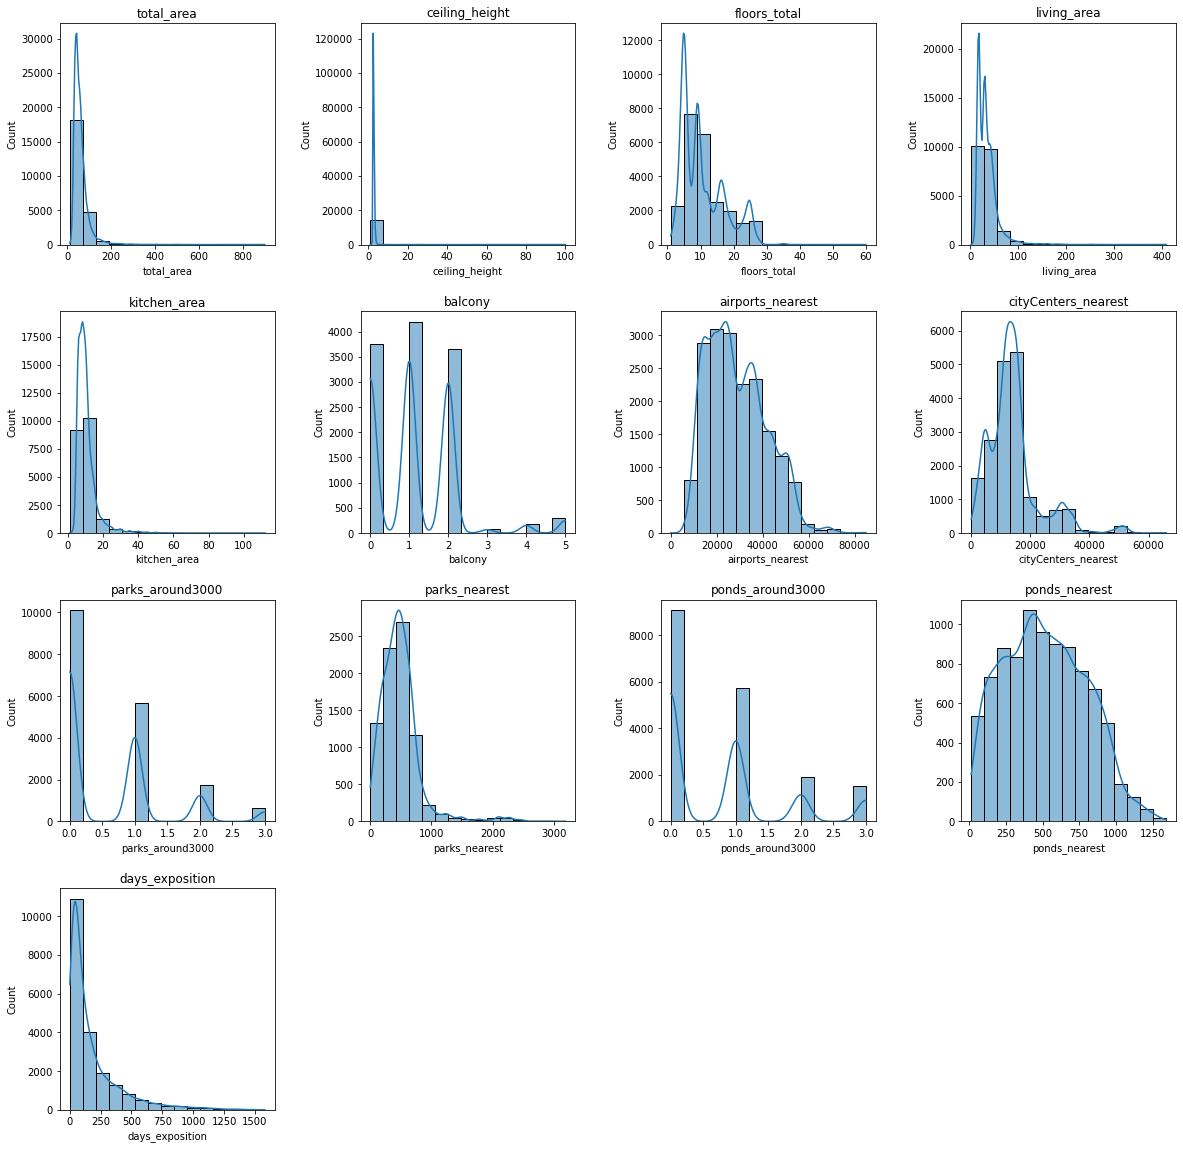

In [10]:
# Построим гистограммы для численных признаков
fig, axs = plt.subplots(4,4, figsize=(20, 20))
fig.subplots_adjust(hspace = 0.3, wspace=0.4)
axs = axs.ravel()

for i in range(len(axs)):
    if i >= len(num_cols):
        axs[i].axis('off')
        continue
    sns.histplot(df[num_cols[i]], bins=15, kde=True, ax=axs[i])
    axs[i].set_title(num_cols[i])
    



### Вывод

Мы познакомились с данными, обнаружили множество пропущенных значений и значения, похожие на выбросы или единичные случаи, которые можно удалить. Построенные графики напоминают распределение Пуассона.

Далее разберемся, какие значения пропущены и что с ними делать.

## Шаг 2. Предобработка данных

In [11]:
na_count = df.isna().sum()[df.isna().sum()>0]
na_count

ceiling_height          9195
floors_total              86
living_area             1903
is_apartment           20924
kitchen_area            2278
balcony                11519
locality_name             49
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
parks_nearest          15620
ponds_around3000        5518
ponds_nearest          14589
days_exposition         3181
dtype: int64

#### ceiling_height 

Посмотрим на сомнительные значения

In [12]:
df.ceiling_height.value_counts().sort_index(ascending=False).head(15)

100.0    1
32.0     2
27.5     1
27.0     8
26.0     1
25.0     7
24.0     1
22.6     1
20.0     1
14.0     1
10.3     1
8.3      1
8.0      3
6.0      1
5.8      1
Name: ceiling_height, dtype: int64

In [13]:
df.ceiling_height.value_counts().sort_index(ascending=True).head(5)

1.00     1
1.20     1
1.75     1
2.00    11
2.20     1
Name: ceiling_height, dtype: int64

Удалим объявления с потолками больше 10 метров и меньше 2 метров

In [14]:
print(f'Доля удаленных значений: {df[(df.ceiling_height>10) | (df.ceiling_height<2)].shape[0]/df.shape[0]:.2%}')  # new
df.drop(df[(df.ceiling_height>10) | (df.ceiling_height<2)].index, inplace=True)

df.ceiling_height.describe()

Доля удаленных значений: 0.12%


count    14476.000000
mean         2.728272
std          0.292510
min          2.000000
25%          2.517500
50%          2.650000
75%          2.800000
max          8.300000
Name: ceiling_height, dtype: float64

Медиана и среднее находяться достаточно близко к друг другу, заполним пропущенные значения медианой

In [15]:
df.ceiling_height.fillna(df.ceiling_height.median(), inplace=True)

#### floors_total

In [16]:
df.floors_total.describe()

count    23585.000000
mean        10.674115
std          6.593091
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [17]:
df.floors_total.value_counts().sort_index(ascending=False).head(10)

60.0      1
52.0      1
36.0      2
35.0     24
34.0      1
33.0      1
29.0      1
28.0     21
27.0    164
26.0    124
Name: floors_total, dtype: int64

In [18]:
# Посмотрим на самые высокие здания Санкт-Петергбурга
documentation = IFrame(src='https://ru.wikipedia.org/wiki/\
                       %D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B0%D0%BC%D1%8B%D1%85\
                       _%D0%B2%D1%8B%D1%81%D0%BE%D0%BA%D0%B8%D1%85_%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B9\
                       _%D0%A1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D0%B0',
                       width=1000, height=500)
display(documentation)

Удалим объявления с общим количеством этажей больше 37

In [19]:
df.drop(df[df.floors_total>37].index, inplace=True)

Заполнять пропущенные значения не будем

#### living_area

In [21]:
df.living_area.describe()

count    21766.000000
mean        34.462816
std         22.039436
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Согласно действующим СНиПам, минимальная площадь комнаты должна быть не менее 8 квадратных метров (п. 5.3 СП 5.413330.2011)

In [22]:
df[df.living_area<8].shape[0]

8

In [23]:
df[df.living_area<8].is_apartment

3242     NaN
13915    NaN
16431    NaN
17582    NaN
19251    NaN
21758    NaN
21943    NaN
23574    NaN
Name: is_apartment, dtype: object

Удалим плохие значения

In [24]:
df.drop(df[df.living_area<8].index,inplace=True)

Пропущенные значения заменим средним отношением к общей площади

In [25]:
df.living_area.fillna((df.living_area/df.total_area).mean()*df.total_area, inplace=True)

#### is_apartment

In [26]:
df.is_apartment.value_counts()

False    2716
True       47
Name: is_apartment, dtype: int64

Заполним пропуски False, т.к. если жилье является аппартаментами - это явно указали бы, в другом случае вопрос могли пропустить

In [27]:
df.is_apartment.fillna(False, inplace=True)

#### kitchen_area

In [28]:
df.kitchen_area.describe()

count    21390.000000
mean        10.570612
std          5.908262
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Площадь кухни должна быть не менее 5 метров квадратных

In [29]:
print(df[df.kitchen_area<5].studio.sum())
print(df[df.kitchen_area<5].open_plan.sum())
print(df[df.kitchen_area<5].is_apartment.sum())
df[df.kitchen_area<5].shape[0]

0
0
0


105

Удалим кваритры с кухнями менее 5 метров квадратных

In [30]:
df.drop(df[df.kitchen_area<5].index, inplace=True)

Заполним пропуски средним отношением к общей площади или минимальной площадью кухни - 5 метров.

In [31]:
df.kitchen_area.fillna((df.kitchen_area/df.total_area).mean()*df.total_area, inplace=True)
df.kitchen_area[df.kitchen_area<5] = 5

In [32]:
df.kitchen_area.describe()

count    23556.000000
mean        10.611660
std          6.091288
min          5.000000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

#### balcony

In [33]:
df.balcony.value_counts().sort_index()

0.0    3741
1.0    4167
2.0    3637
3.0      81
4.0     181
5.0     300
Name: balcony, dtype: int64

Будем считать, если люди не указали информацию о балконах, значит их нет

In [34]:
df.balcony.fillna(0, inplace=True)

#### locality_name

In [35]:
print(df.locality_name.isna().sum())
df.locality_name.value_counts()

49


Санкт-Петербург                        15646
посёлок Мурино                           517
посёлок Шушары                           438
Всеволожск                               398
Пушкин                                   366
                                       ...  
поселок городского типа Кондратьево        1
поселок Кирпичное                          1
деревня Щеглово                            1
деревня Терпилицы                          1
деревня Мины                               1
Name: locality_name, Length: 362, dtype: int64

Удалим объявления без указания населенного пункта

In [36]:
print(f'Доля удаленных значений: {df[df.locality_name.isna()].shape[0]/df.shape[0]:.2%}')  # new
df.drop(df[df.locality_name.isna()].index, inplace=True)

Доля удаленных значений: 0.21%


Видим слово *поселок* пишут через *е* и *ё*, поменяем все *ё* на *е*.

In [37]:
keys = df.locality_name.unique()
values = df.locality_name.unique()
for i, word in enumerate(values):
    values[i] = word.replace('ё', 'е')
locality_names = dict(zip(keys,values)) 

df.locality_name.replace(locality_names, inplace=True)

In [38]:
lemmas = Mystem().lemmatize(' '.join(df.locality_name.unique()))
lemmas

Counter(lemmas).most_common()[:25]

[(' ', 747),
 ('поселок', 166),
 ('деревня', 105),
 ('городской', 43),
 ('тип', 30),
 ('-', 10),
 ('село', 10),
 ('станция', 8),
 ('большой', 7),
 ('бор', 6),
 ('старый', 6),
 ('новый', 5),
 ('товарищество', 5),
 ('садовый', 4),
 ('малый', 4),
 ('красный', 3),
 ('павлово', 3),
 ('ижора', 3),
 ('лесной', 3),
 ('коттеджный', 3),
 ('муриный', 2),
 ('кудрово', 2),
 ('коммунар', 2),
 ('федоровский', 2),
 ('ропша', 2)]

In [39]:
print(len(df.locality_name.unique()))
df.locality_name.unique()

328


array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

*'Поселок городского типа Павлово'* и *'городской поселок Павлово'*, видимо одно и тоже место, заменим *городской поселок* на *поселок городского типа*

In [40]:
keys = values.copy()
for i, word in enumerate(values):
    values[i] = word.replace('городской поселок', 'поселок городского типа')
locality_names = dict(zip(keys,values)) 

df.locality_name.replace(locality_names, inplace=True)
print(len(df.locality_name.unique()))

321


Заметим, что некоторые названия встречаются с типом населеного пункта и без, например, *'Никольское'* и *'село Никольское'*, разные ли это места или одно и тоже - надо разбираться в каждом конкретном случае

#### airports_nearest        

In [41]:
df.airports_nearest.describe()

count    18020.000000
mean     28808.236238
std      12614.419321
min          0.000000
25%      18585.000000
50%      26760.500000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [42]:
df.groupby('locality_name').airports_nearest.mean()

locality_name
Бокситогорск           NaN
Волосово               NaN
Волхов                 NaN
Всеволожск             NaN
Выборг                 NaN
                        ..
село Путилово          NaN
село Рождествено       NaN
село Русско-Высоцкое   NaN
село Старая Ладога     NaN
село Шум               NaN
Name: airports_nearest, Length: 321, dtype: float64

Расстояния до аэропорта указано для Санкт-Петербурга и ближайших районов, для остальных населеных пунктов указано NaN, оставим как есть.

#### cityCenters_nearest

In [43]:
df.cityCenters_nearest.describe()

count    18043.000000
mean     14182.422269
std       8574.410169
min        181.000000
25%       9238.000000
50%      13105.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [44]:
df.groupby('locality_name')['cityCenters_nearest'].mean()

locality_name
Бокситогорск           NaN
Волосово               NaN
Волхов                 NaN
Всеволожск             NaN
Выборг                 NaN
                        ..
село Путилово          NaN
село Рождествено       NaN
село Русско-Высоцкое   NaN
село Старая Ладога     NaN
село Шум               NaN
Name: cityCenters_nearest, Length: 321, dtype: float64

Расстояния до центра города указано для Санкт-Петербурга и ближайших районов, для остальных населеных пунктов указано NaN, оставим как есть.

#### parks_around3000

In [45]:
df.parks_around3000.value_counts()

0.0    10020
1.0     5648
2.0     1735
3.0      641
Name: parks_around3000, dtype: int64

Заменим пропуещнные значения на '0'

In [46]:
df.parks_around3000.fillna(0, inplace=True)

#### parks_nearest

In [47]:
df.parks_nearest.describe()

count    8028.000000
mean      490.913926
std       343.119088
min         1.000000
25%       287.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Видим, что парки, находящиеся дальше 3190 метров, не учтены. Заполнять пропущенные значения не будем.

#### ponds_around3000

In [48]:
df.parks_around3000.value_counts()

0.0    15483
1.0     5648
2.0     1735
3.0      641
Name: parks_around3000, dtype: int64

Заменим пропуещнные значения на '0'

In [49]:
df.parks_around3000.fillna(0, inplace=True)

#### ponds_nearest

In [50]:
df.ponds_nearest.describe()

count    9033.000000
mean      518.155098
std       277.480341
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

Заполнять пропущенные значения не будем.

#### days_exposition

In [51]:
df.days_exposition.describe()

count    20347.000000
mean       180.915319
std        219.917211
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Пропущенные значения могут означать, что объявления еще не сняли. Можно заполнить пропуски максимальным значением, но пока оставим как есть.

### Переопределим типы столбцов, где необходимо 

In [52]:
df.reset_index(inplace=True,drop=True)

In [53]:
int_cols = ['last_price', 'balcony']
cols_with_nans = ['airports_nearest', 'cityCenters_nearest', 'parks_nearest',
                  'ponds_around3000', 'ponds_nearest', 'days_exposition'
                 ]
bool_col = 'is_apartment'
cat_col = 'locality_name'
date_col = 'first_day_exposition' 

df[int_cols] = df[int_cols].astype('int')
df[bool_col] = df[bool_col].astype('bool')
df[cat_col] = df[cat_col].astype('category')

df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%dT%H:%M:%S')


### Вывод

 - Обработали все столбцы с пропущенными значениями, заполнили пропуски, где было возможно
 - Удалили объявления с ошибками, которые удалось выделить, например, 100-метровые потолки или жилая площадь меньше минимально допустимой
 - Привели названия населенных пунктов к одинаковому написанию
 - Привели колонки к нужным типам для экономии памяти

## Шаг 3. Посчитайте и добавьте в таблицу

#### Добавляем цену квадратного метра

In [54]:
df['price_per_square_meter'] = df.last_price/df.total_area

#### Добавляем день недели, месяц и год публикации

In [55]:
df['day_exposition'] = df.first_day_exposition.dt.day
df['day_of_week_exposition'] = df.first_day_exposition.dt.dayofweek
df['month_exposition'] = df.first_day_exposition.dt.month
df['year_exposition'] = df.first_day_exposition.dt.year

week_dict={0:'Пн', 1:'Вт', 2:'Ср', 3:'Чт', 4:'Пт', 5:'Сб', 6:'Вс'}
df['day_of_week_exposition'].replace(week_dict, inplace=True)
df['day_of_week_exposition'] = df['day_of_week_exposition'].astype('category')


#### Добавляем этаж квартиры

In [56]:
def floor_cat(floor, floors_total):
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другое'

df['floor_cat'] = df.apply(lambda row: floor_cat(row.floor, row.floors_total), axis=1).astype('category')

#### Добавляем соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [57]:
df['living/total'] = df.living_area / df.total_area
df['kitchen/total'] = df.kitchen_area / df.total_area

Посчитали и добавили цену квадратного метра, день, месяц и год публикации, категорию этажа квартиры и соотношение жилой площади и площади кухни к общей площади. 

## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Строим гистрограммы 

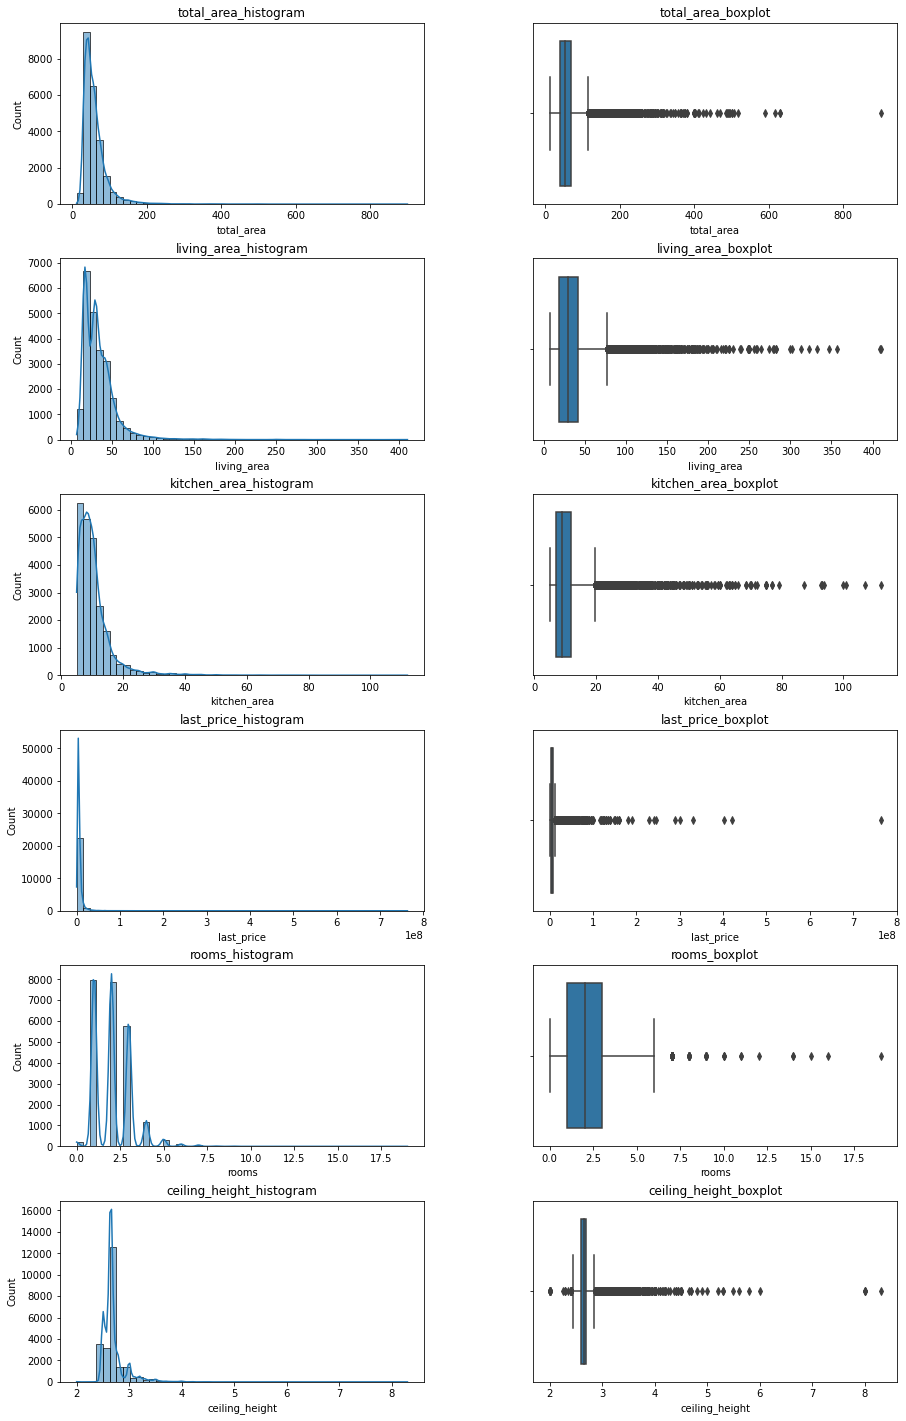

In [58]:
cols_for_hist = ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height']

def hist_plotting():
    fig, axs = plt.subplots(6,2, figsize=(15, 25))
    fig.subplots_adjust(hspace = 0.3, wspace=0.3)
    axs = axs.ravel()

    for i in range(0,12,2):

        sns.histplot(df[cols_for_hist[i//2]], bins=50, kde=True, ax=axs[i])
        axs[i].set_title(cols_for_hist[i//2]+'_histogram')

        sns.boxplot(df[cols_for_hist[i//2]], ax=axs[i+1])
        axs[i+1].set_title(cols_for_hist[i//2]+'_boxplot')

hist_plotting()


<font color='blue'> New </font>
- `total_area` -  обычное распределение Пуассона с длинным хвостом, возможно, обявления за правым усом относятся к категории для богатых клиентов и имеют свое собственное распределение
- `living_area` - на гистограмме жилой площади видим два пика, видимо, это типичные представители разных типов квартир, скорее всего, одно- и двухкомнатных
- `kitchen_area` - аналогично гистограмме общей площади
- `last_price` - аналогично гистограмме общей площади
- `rooms` - дискретная величина с редкими обявлениями больше 6 комнат
- `ceiling_height` - видим несколько пиков на гистограмме, видимо, это связано с разными типами застройки, например, пятиэтажки и девятиэтажки 


#### Анализируем время продажи квартир

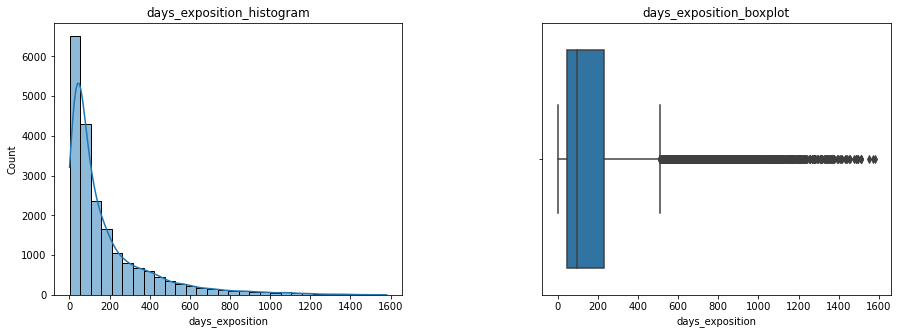

In [59]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
fig.subplots_adjust(hspace = 0.3, wspace=0.4)
axs = axs.ravel()

sns.histplot(df.days_exposition, bins=30, kde=True, ax=axs[0])
axs[0].set_title('days_exposition_histogram')

sns.boxplot(df.days_exposition, ax=axs[1])
axs[1].set_title('days_exposition_boxplot');

In [60]:
df.days_exposition.describe()

count    20347.000000
mean       180.915319
std        219.917211
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Обычно продажа квартиры занимает около 95 дней, если квартиру продали быстрее 45 дней, то продажи прошли очень быстро, дольше 231 дня - долго, дольше 500 дней - необычайно долго.

#### Убираем редкие и выбивающиеся значения

In [61]:
print('Количество значений за "усами"')
print()
for col in cols_for_hist + ['days_exposition']:
    quantile25 = df[col].quantile(0.25)
    quantile75 = df[col].quantile(0.75)
    threshold = (quantile75 - quantile25)*1.5 + quantile75
    print(f'{col:.<15}', df[col][df[col] > threshold].shape[0])

Количество значений за "усами"

total_area..... 1213
living_area.... 884
kitchen_area... 1340
last_price..... 2058
rooms.......... 90
ceiling_height. 2870
days_exposition 1665


Удалять все значения за усами не будем, т.к. их слишком много, удалим лишь самые крайние.

Доля удаленных значений: 0.23%



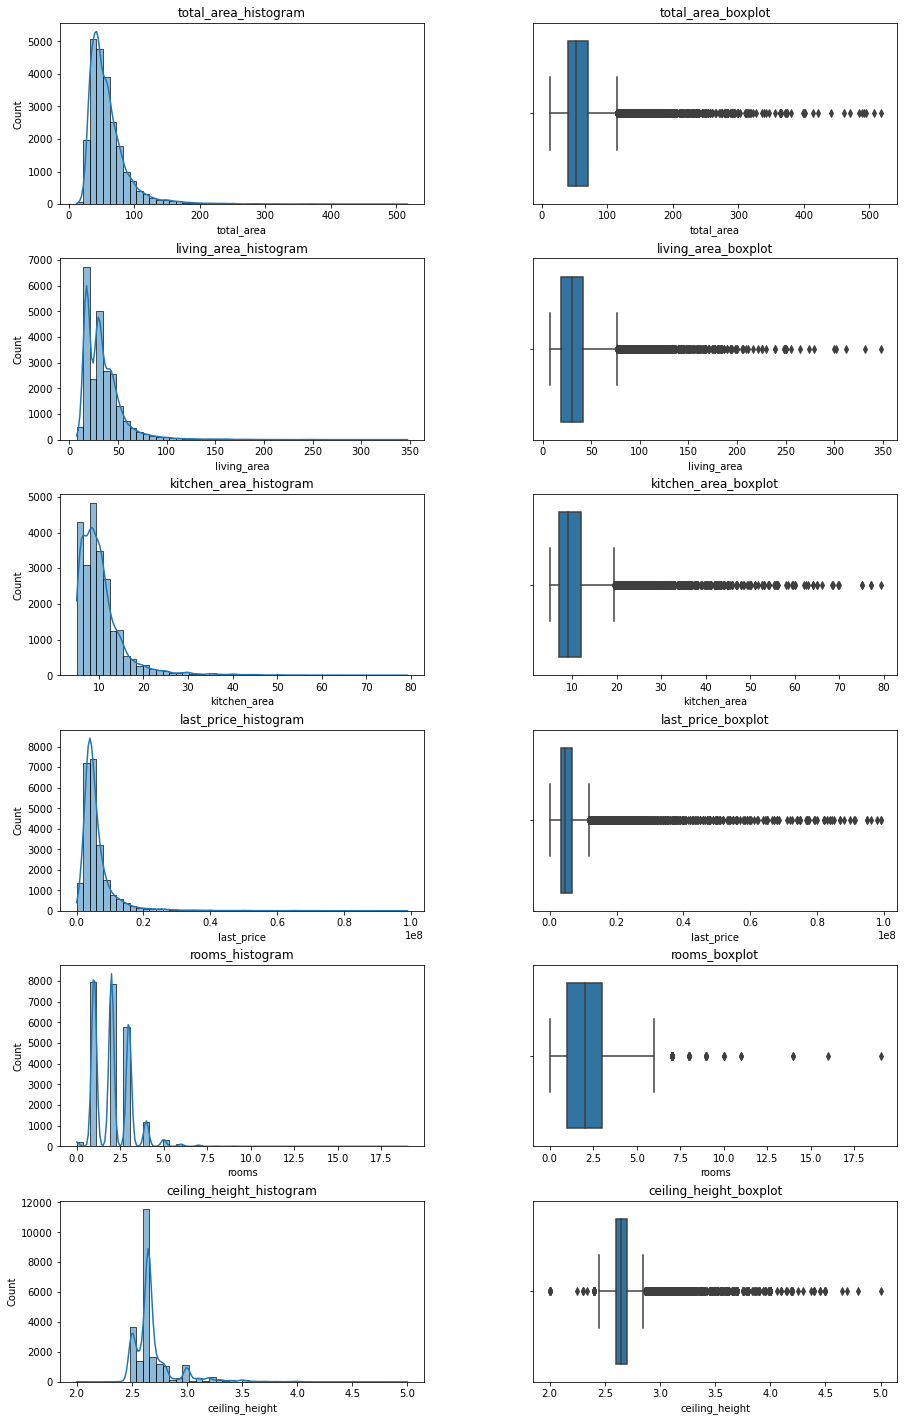

In [62]:
print(f'Доля удаленных значений: {df[(df.total_area>570) | (df.living_area>400) | (df.kitchen_area>80) | (df.last_price>100000000) | (df.ceiling_height>5) | (df.days_exposition>1560)].shape[0]/df.shape[0]:.2%}')  # new
print()
df.drop(df[df.total_area>570].index, inplace=True)
df.drop(df[df.living_area>400].index, inplace=True)
df.drop(df[df.kitchen_area>80].index, inplace=True)
df.drop(df[df.last_price>100000000].index, inplace=True)
df.drop(df[df.ceiling_height>5].index, inplace=True)
df.drop(df[df.days_exposition>1560].index, inplace=True)
hist_plotting()

#### Изучаем факторы, которые больше всего влияют на стоимость квартиры

Корреляция цены с другими параметрами:

total_area.......... 0.7696757858816893
rooms............... 0.47444449128150057
floor............... 0.0371284044643741
cityCenters_nearest. -0.30213511457890185
days_exposition..... 0.12248975454093593



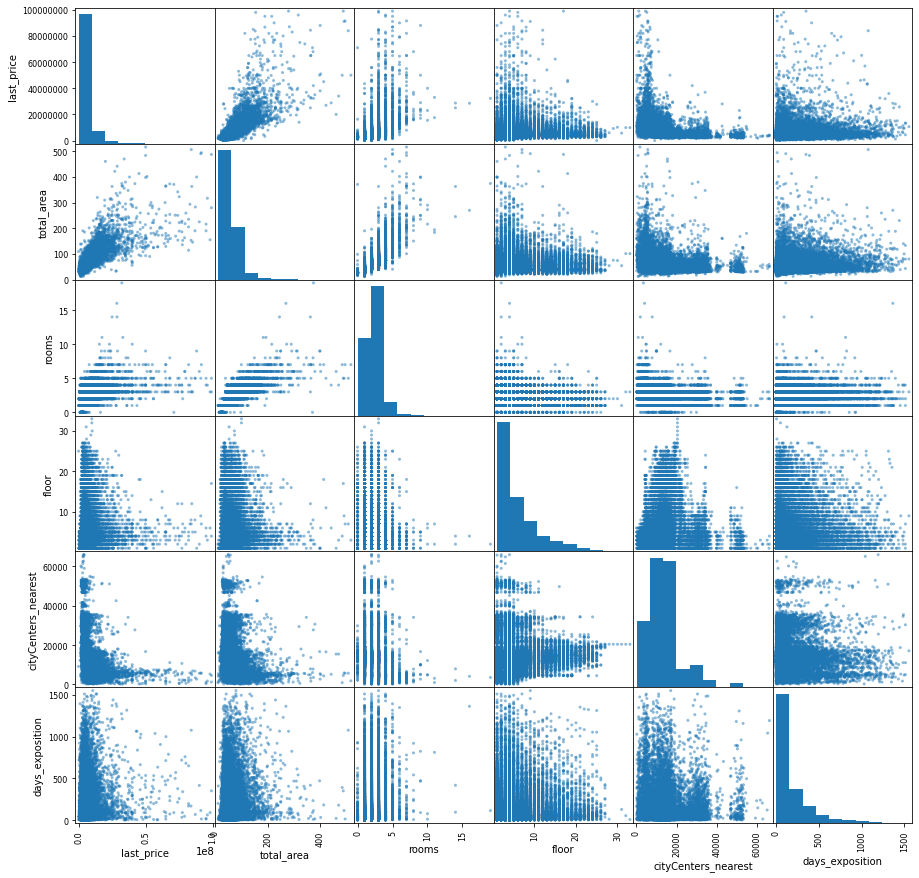

In [63]:
print('Корреляция цены с другими параметрами:')
print()
for col in ['total_area', 'rooms', 'floor', 'cityCenters_nearest', 'days_exposition']:
    corr = df.last_price.corr(df[col])
    print(f'{col:.<20}', corr)
print()    
pd.plotting.scatter_matrix(df[['last_price', 'total_area', 'rooms', 'floor', 'cityCenters_nearest', 'days_exposition']], figsize=(15, 15)); # new

Логично, что самая высокая корреляция цены - с площадью квартиры, а так же с количеством комнат. Удаленность от центра влияет меньше.

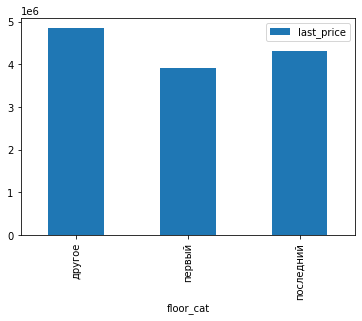

In [64]:
df.pivot_table(index='floor_cat', values='last_price', aggfunc='median').plot(kind='bar');

Квартиры на первом этаже заметно дешевле остальных.

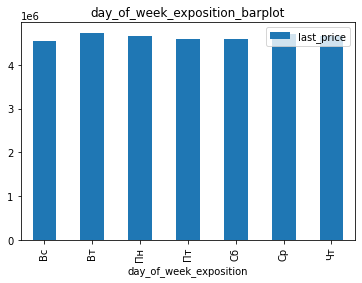

In [65]:
ax = df.pivot_table(index='day_of_week_exposition', values='last_price', aggfunc='median').plot(kind='bar')
ax.set_title('day_of_week_exposition_barplot');

Цена от дня недели зависят слабо.

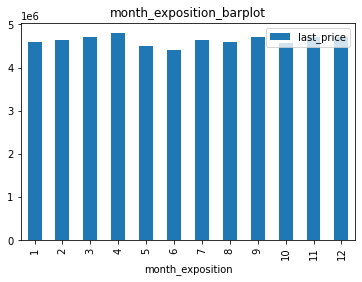

In [66]:
ax = df.pivot_table(index='month_exposition', values='last_price', aggfunc='median').plot(kind='bar')
ax.set_title('month_exposition_barplot');

В Июне цены на квартиры ниже всего. Возможно это из-за начала сезона отпусков и, просто, большей расслабленностью людей летом.

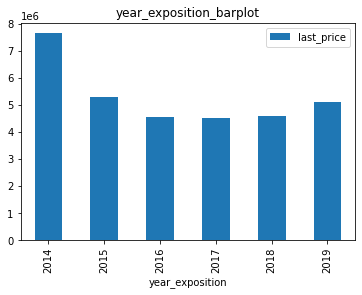

In [67]:
ax = df.pivot_table(index='year_exposition', values='last_price', aggfunc='median').plot(kind='bar')
ax.set_title('year_exposition_barplot');

После 2014 цены на жилье начали заметно дешеветь, возможно это связано с внешней политикой нашей страны, состоянием экономики и другими факторами.

#### 10 населённых пунктов с наибольшим числом объявлений

In [68]:
local_names = df.locality_name.value_counts().head(10).index
df[df.locality_name.isin(local_names)].pivot_table(index='locality_name', values='price_per_square_meter').sort_values(by='price_per_square_meter').round(2)

,price_per_square_meter
locality_name,
Выборг,58188.87
Всеволожск,68654.47
Гатчина,68858.48
Колпино,75424.58
поселок Шушары,78513.33
поселок Мурино,85522.24
поселок Парголово,90175.91
деревня Кудрово,92473.55
Пушкин,103188.21


Как и ожидалось, дороже все в Питере.

 #### Выясняем, какая область входит в центр

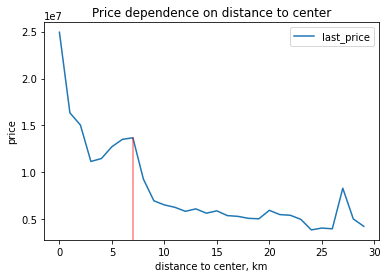

In [69]:
inds = (df[df.locality_name=='Санкт-Петербург'].cityCenters_nearest/1000).round(0)
ax = df[df.locality_name=='Санкт-Петербург'].pivot_table(index=inds.values, values='last_price').plot()
ax.axvline(7,ymax=0.47,c='red', alpha=0.5)  # new
ax.set_title('Price dependence on distance to center')
ax.set_xlabel('distance to center, km')
ax.set_ylabel('price');

Положим центром города область радусом 7 километров.

#### Выделяем сегмент квартир в центре

Корреляция цены с другими параметрами:

total_area.......... 0.7207577258956801
rooms............... 0.3979548499712487
floor............... 0.15614325303190832
cityCenters_nearest. -0.03976390098763366
days_exposition..... 0.1022390263775799



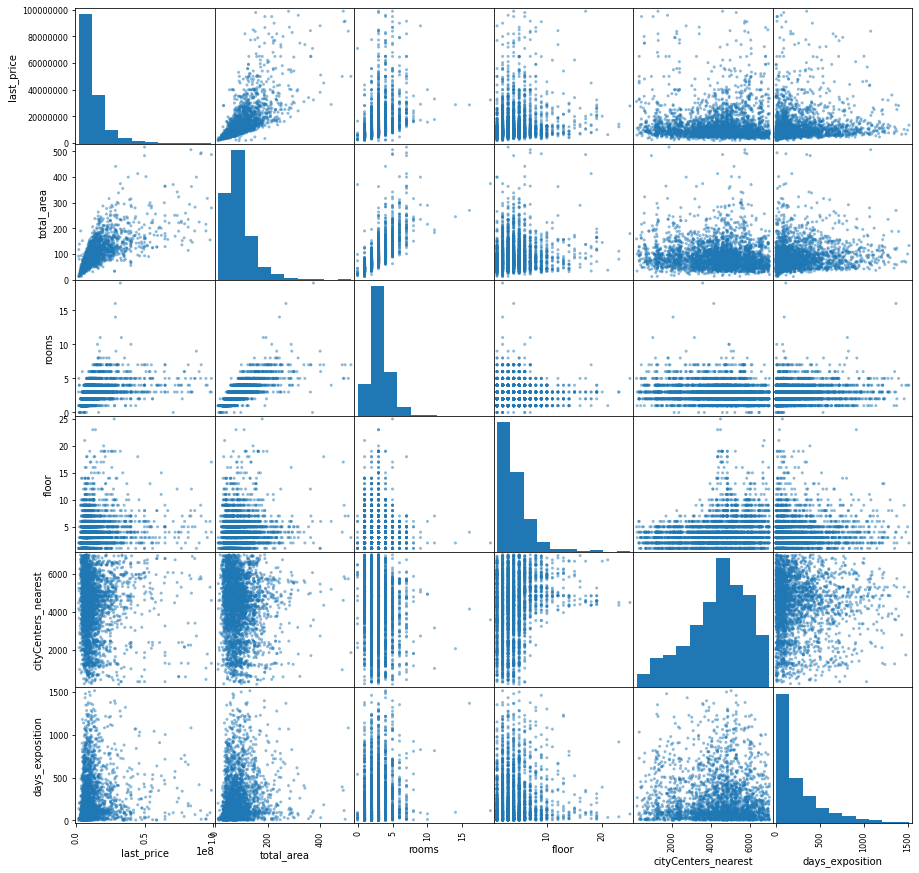

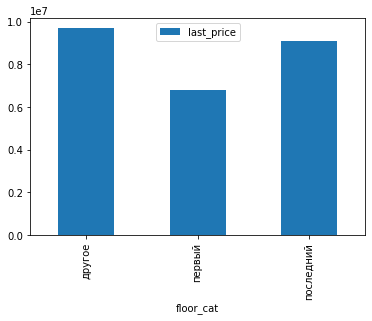

In [70]:
df[df.cityCenters_nearest<7000]

print('Корреляция цены с другими параметрами:')
print()
for col in ['total_area', 'rooms', 'floor', 'cityCenters_nearest', 'days_exposition']:
    corr = df[df.cityCenters_nearest<7000].last_price.corr(df[df.cityCenters_nearest<7000][col])
    print(f'{col:.<20}', corr)
print()
pd.plotting.scatter_matrix(df[['last_price', 'total_area', 'rooms', 'floor', 'cityCenters_nearest', 'days_exposition']][df.cityCenters_nearest<7000], figsize=(15, 15)); # new

df[df.cityCenters_nearest<7000].pivot_table(index='floor_cat', values='last_price', aggfunc='median').plot(kind='bar');


Квартиры в центре на первом этаже продают еще дешевле, чем на этажах повыше, возможно, это связано с бОльшим количество людей на улицах в центре. 

Зависимости цены от площади и количества комнат почти не изменились.

Еще раз посмотрим на наши числовые признаки

In [71]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23452.0,9.857283e+00,5.677792e+00,0.000000,6.000000e+00,9.000000e+00,1.400000e+01,5.000000e+01
last_price,23452.0,6.241343e+06,6.328109e+06,12190.000000,3.440000e+06,4.650000e+06,6.782500e+06,9.900000e+07
total_area,23452.0,5.992678e+01,3.304595e+01,12.000000,4.000000e+01,5.200000e+01,6.970000e+01,5.170000e+02
rooms,23452.0,2.066647e+00,1.067162e+00,0.000000,1.000000e+00,2.000000e+00,3.000000e+00,1.900000e+01
ceiling_height,23452.0,2.695441e+00,2.135399e-01,2.000000,2.600000e+00,2.650000e+00,2.700000e+00,5.000000e+00
floors_total,23368.0,1.069287e+01,6.576812e+00,1.000000,5.000000e+00,9.000000e+00,1.600000e+01,3.600000e+01
living_area,23452.0,3.432250e+01,2.107073e+01,7.343620,1.900000e+01,3.000000e+01,4.200000e+01,3.475000e+02
floor,23452.0,5.898729e+00,4.884092e+00,1.000000,2.000000e+00,4.000000e+00,8.000000e+00,3.300000e+01
kitchen_area,23452.0,1.052629e+01,5.675554e+00,5.000000,7.000000e+00,9.100000e+00,1.200000e+01,7.923241e+01
balcony,23452.0,5.912076e-01,9.582987e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00


## Шаг 5. Общий вывод

В данных оказалось много пропущенных значений, выбросов, ошибок. После обработки мы избавились от большинства найденных проблем и подготовили данные для дальнейшего исследования.

В среднем, квартиру в Питере и прилегающих районах можно купить за 4.65 млн.р., это будет 2-х комнатная квартира 52 кв.м. в девятиэтажном доме с ближайшим парком в 5-ти километрах.

В нашей работе мы выяснили, что в основном стоимость квартиры зависит от ее площади (коэффициент корреляции 0.77), количества комнат (коэффициент корреляции 0.47) и расстояния до центра (коэффициент корреляции -0.33), на первом этаже квартиры дешевле, а в разные года цена может сильно отличаться. В центре города стоимость квартир чуть меньше зависит от площади (коэффициент корреляции 0.72) и почти не зависит от расстояния (коэффициент корреляции -0.04), остальные показатели на уровне всего города.